# Multi-strategy workflow with reflection

In this notebook we'll demonstrate a workflow that attempts 3 different query strategies in parallel and picks the best one.

As shown in the diagram below:
* First the quality of the query is judged. If it's a bad query, a `BadQueryEvent` is emitted and the `improve_query` step will try to improve the quality of the query before trying again. This is reflection.
* Once an acceptable query has been found, three simultaneous events are emitted: a `NaiveRAGEvent`, a `HighTopKEvent`, and a `RerankEvent`.
* Each of these events is picked up by a dedicated step that tries a different RAG strategy on the same index. All 3 emit a `ResponseEvent`
* The `judge` step waits until it has collected all three `ResponseEvents`, then it compares them. It finally emits the best response as a `StopEvent`

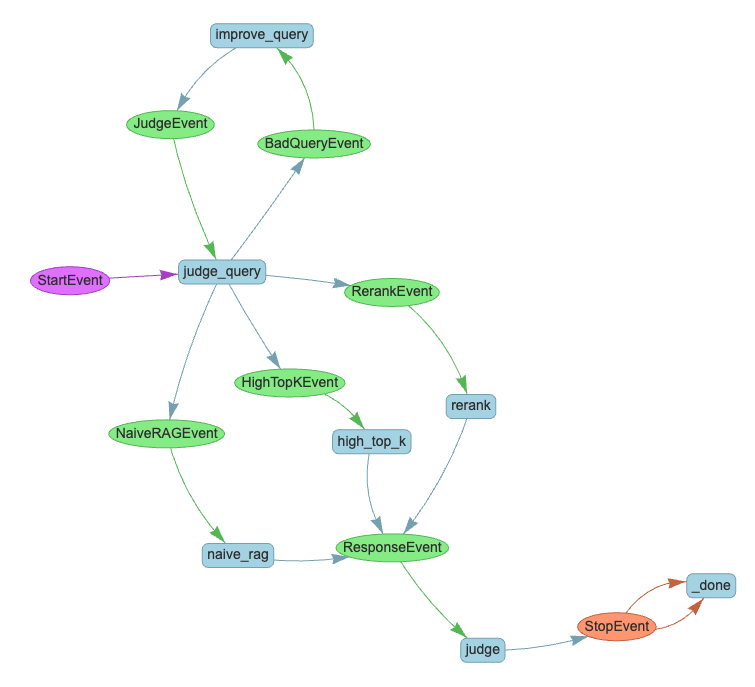

## Install dependencies

We need LlamaIndex, the file reader (for reading PDFs), the workflow visualizer (to draw the diagram above), and OpenAI to embed the data and query an LLM.

In [ ]:
!pip install llama-index-core llama-index-llms-openai llama-index-utils-workflow llama-index-readers-file llama-index-embeddings-openai

## Get the data

We are using 3 long PDFs of San Francisco's annual budget from 2016 through 2018.

In [ ]:
!mkdir data
!wget "https://www.dropbox.com/scl/fi/xt3squt47djba0j7emmjb/2016-CSF_Budget_Book_2016_FINAL_WEB_with-cover-page.pdf?rlkey=xs064cjs8cb4wma6t5pw2u2bl&dl=0" -O "data/2016-CSF_Budget_Book_2016_FINAL_WEB_with-cover-page.pdf"
!wget "https://www.dropbox.com/scl/fi/jvw59g5nscu1m7f96tjre/2017-Proposed-Budget-FY2017-18-FY2018-19_1.pdf?rlkey=v988oigs2whtcy87ti9wti6od&dl=0" -O "data/2017-Proposed-Budget-FY2017-18-FY2018-19_1.pdf"
!wget "https://www.dropbox.com/scl/fi/izknlwmbs7ia0lbn7zzyx/2018-o0181-18.pdf?rlkey=p5nv2ehtp7272ege3m9diqhei&dl=0" -O "data/2018-o0181-18.pdf"

## Bring in dependencies

Now we import all our dependencies

In [ ]:
import os
from llama_index.core import (
    SimpleDirectoryReader,
    VectorStoreIndex,
    StorageContext,
    load_index_from_storage,
)
from llama_index.core.workflow import (
    step,
    Context,
    Workflow,
    Event,
    StartEvent,
    StopEvent,
)
from llama_index.llms.openai import OpenAI
from llama_index.core.postprocessor.rankGPT_rerank import RankGPTRerank
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.chat_engine import SimpleChatEngine
from llama_index.utils.workflow import draw_all_possible_flows

We also need to set up our OpenAI key.

In [ ]:
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get("openai-key")

## Define event classes

Our flow generates quite a few different event types.

In [ ]:
class JudgeEvent(Event):
    query: str


class BadQueryEvent(Event):
    query: str


class NaiveRAGEvent(Event):
    query: str


class HighTopKEvent(Event):
    query: str


class RerankEvent(Event):
    query: str


class ResponseEvent(Event):
    query: str
    response: str


class SummarizeEvent(Event):
    query: str
    response: str

## Define workflow

This is the substance of our workflow, so let's break it down:

* `load_or_create_index` is a normal RAG function that reads our PDFs from disk and indexes them if they aren't already indexed. If indexing already happened it will simply restore the existing index from disk.

* `judge_query` does a few things
  * It initializes the LLM and calls `load_or_create_index` to get set up. It stores these things in the context so they are available later.
  * It judges the quality of the query
  * If the query is bad it emits a `BadQueryEvent`
  * If the query is good it emits a `NaiveRAGEvent`, a `HighTopKEvent` and a `RerankerEvent`

* `improve_query` takes the `BadQueryEvent` and uses an LLM to try and expand and deambiguate the query if possible, then it loops back to `judge_query`

* `naive_rag`, `high_top_k` and `rerank` accept their respective events and attempt 3 different RAG strategies. Each emits a `ResponseEvent` with their result and a `source` parameter that says which strategy was used

* `judge` fires every time a `ResponseEvent` is emitted, but it uses `collect_events` to buffer them until it has received all 3. Then it sends the responses to an LLM and asks it to select the "best" one. It emits the best response as a StopEvent

In [ ]:
class ComplicatedWorkflow(Workflow):
    def load_or_create_index(self, directory_path, persist_dir):
        # Check if the index already exists
        if os.path.exists(persist_dir):
            print("Loading existing index...")
            # Load the index from disk
            storage_context = StorageContext.from_defaults(
                persist_dir=persist_dir
            )
            index = load_index_from_storage(storage_context)
        else:
            print("Creating new index...")
            # Load documents from the specified directory
            documents = SimpleDirectoryReader(directory_path).load_data()

            # Create a new index from the documents
            index = VectorStoreIndex.from_documents(documents)

            # Persist the index to disk
            index.storage_context.persist(persist_dir=persist_dir)

        return index

    @step
    async def judge_query(
        self, ctx: Context, ev: StartEvent | JudgeEvent
    ) -> BadQueryEvent | NaiveRAGEvent | HighTopKEvent | RerankEvent:
        # initialize
        llm = await ctx.get("llm", default=None)
        if llm is None:
            await ctx.set("llm", OpenAI(model="gpt-4o", temperature=0.1))
            await ctx.set(
                "index", self.load_or_create_index("data", "storage")
            )

            # we use a chat engine so it remembers previous interactions
            await ctx.set("judge", SimpleChatEngine.from_defaults())

        response = await ctx.get("judge").chat(
            f"""
            Given a user query, determine if this is likely to yield good results from a RAG system as-is. If it's good, return 'good', if it's bad, return 'bad'.
            Good queries use a lot of relevant keywords and are detailed. Bad queries are vague or ambiguous.

            Here is the query: {ev.query}
            """
        )
        if response == "bad":
            # try again
            return BadQueryEvent(query=ev.query)
        else:
            # send query to all 3 strategies
            self.send_event(NaiveRAGEvent(query=ev.query))
            self.send_event(HighTopKEvent(query=ev.query))
            self.send_event(RerankEvent(query=ev.query))

    @step
    async def improve_query(
        self, ctx: Context, ev: BadQueryEvent
    ) -> JudgeEvent:
        response = await ctx.get("llm").complete(
            f"""
            This is a query to a RAG system: {ev.query}

            The query is bad because it is too vague. Please provide a more detailed query that includes specific keywords and removes any ambiguity.
        """
        )
        return JudgeEvent(query=str(response))

    @step
    async def naive_rag(
        self, ctx: Context, ev: NaiveRAGEvent
    ) -> ResponseEvent:
        index = await ctx.get("index")
        engine = index.as_query_engine(similarity_top_k=5)
        response = engine.query(ev.query)
        print("Naive response:", response)
        return ResponseEvent(
            query=ev.query, source="Naive", response=str(response)
        )

    @step
    async def high_top_k(
        self, ctx: Context, ev: HighTopKEvent
    ) -> ResponseEvent:
        index = await ctx.get("index")
        engine = index.as_query_engine(similarity_top_k=20)
        response = engine.query(ev.query)
        print("High top k response:", response)
        return ResponseEvent(
            query=ev.query, source="High top k", response=str(response)
        )

    @step
    async def rerank(self, ctx: Context, ev: RerankEvent) -> ResponseEvent:
        index = await ctx.get("index")
        reranker = RankGPTRerank(top_n=5, llm=await ctx.get("llm"))
        retriever = index.as_retriever(similarity_top_k=20)
        engine = RetrieverQueryEngine.from_args(
            retriever=retriever,
            node_postprocessors=[reranker],
        )
        response = engine.query(ev.query)
        print("Reranker response:", response)
        return ResponseEvent(
            query=ev.query, source="Reranker", response=str(response)
        )

    @step
    async def judge(self, ctx: Context, ev: ResponseEvent) -> StopEvent:
        ready = ctx.collect_events(ev, [ResponseEvent] * 3)
        if ready is None:
            return None

        response = await ctx.get("judge").chat(
            f"""
            A user has provided a query and 3 different strategies have been used
            to try to answer the query. Your job is to decide which strategy best
            answered the query. The query was: {ev.query}

            Response 1 ({ready[0].source}): {ready[0].response}
            Response 2 ({ready[1].source}): {ready[1].response}
            Response 3 ({ready[2].source}): {ready[2].response}

            Please provide the number of the best response (1, 2, or 3).
            Just provide the number, with no other text or preamble.
        """
        )

        best_response = int(str(response))
        print(
            f"Best response was number {best_response}, which was from {ready[best_response-1].source}"
        )
        return StopEvent(result=str(ready[best_response - 1].response))

## Draw flow diagram

This is how we get the diagram we showed at the start.

In [ ]:
draw_all_possible_flows(
    ComplicatedWorkflow, filename="complicated_workflow.html"
)

## Run the workflow

Let's take the workflow for a spin:
* The judge_query event returned nothing. This is because it used `send_event` instead. So the query was judged "good".
* All 3 RAG steps run and generate different answers to the query
* The `judge` step runs 3 times. The first 2 times it produces no event, because it has not collected the requisite 3 `ResponseEvent`s.
* On the third time it selects the best response and returns a `StopEvent`

In [ ]:
c = ComplicatedWorkflow(timeout=120, verbose=True)
result = await c.run(
    # query="How has spending on police changed in San Francisco's budgets from 2016 to 2018?"
    # query="How has spending on healthcare changed in San Francisco?"
    query="How has spending changed?"
)
print(result)

Running step judge_query
Creating new index...
Step judge_query produced no event
Running step naive_rag
Naive response: Spending has increased over the years due to various factors such as new voter-approved minimum spending requirements, the creation of new voter-approved baselines, and growth in baseline funded requirements. Additionally, there have been notable changes in spending across different service areas and departments, with increases in funding for areas like public protection, transportation, and public works.
Step naive_rag produced event ResponseEvent
Running step rerank
Reranker response: Spending has increased over the years, with notable changes in the allocation of funds to various service areas and departments. The budget reflects adjustments in spending to address evolving needs and priorities, resulting in a rise in overall expenditures across different categories.
Step rerank produced event ResponseEvent
Running step high_top_k
High top k response: Spending has 